#AI Final Project
##Material Classification Via Audio
---
###Mohammad Hossein Ebrahimi
###Amir Hossein Jamehbozorg
###Sobhan Mashhadi

**کتابخانه**

In [1]:
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

اضافه کردن اکانت گوگل

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


   *** حذف نویز و در صورت نیاز نرمال‌سازی سیگنال صوتی به محدوده [-1, 1]  برای استفاده از ویژگی هایی مانند فرکانس میانگین**

In [3]:
def preprocess_audio(audio, sr):

    audio = librosa.effects.preemphasis(audio)

    # audio = librosa.util.normalize(audio)

    return audio

**استخراج ویژگی ها بر اساس نیاز**

In [4]:
# استخراج ویژگی‌های MFCC و سایر ویژگی‌ها از یک فایل صوتی
def extract_features(file_path):
    # بارگذاری فایل صوتی
    audio, sr = librosa.load(file_path, sr=None)

    # استخراج ویژگی‌های MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # استخراج ویژگی‌های Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    spectral_contrast_mean = np.mean(spectral_contrast, axis=1)

    # استخراج ویژگی‌های Chroma
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)


    #Zero Crossing Rate (ZCR): تعداد عبورهای صفر سیگنال.
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_spec_mean = np.mean(mel_spec, axis=1)


    # ویژگی‌های Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(audio)
    zcr_mean = np.mean(zcr)

  # ویژگی‌های فلاتر
    flatness = librosa.feature.spectral_flatness(y=audio)
    flatness_mean = np.mean(flatness)

    # # ویژگی‌های انرژی
    # energy = np.sum(audio**2) / len(audio)

    # # ویژگی‌های رول‌آف فرکانسی
    # spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85)
    # spectral_rolloff_mean = np.mean(spectral_rolloff)

    # # ویژگی‌های عرض باند
    # bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    # bandwidth_mean = np.mean(bandwidth)


    # #استخراج فرکانس غالب (Dominant Frequency)
    # fft = np.fft.fft(audio)
    # freqs = np.fft.fftfreq(len(fft), 1/sr)
    # magnitude = np.abs(fft)
    # dominant_freq = freqs[np.argmax(magnitude[:len(magnitude)//2])]  # فرکانس غالب

    # # استخراج میانگین فرکانس (Mean Frequency)
    # weighted_sum = np.sum(freqs[:len(magnitude)//2] * magnitude[:len(magnitude)//2])
    # mean_freq = weighted_sum / np.sum(magnitude[:len(magnitude)//2])


    #------------------------------------------------------------------------------------------------------------------------------------

    features = np.hstack([
         mfcc_mean,
         spectral_contrast_mean,     # کنتراست طیفی
         chroma_mean ,
         mel_spec_mean  ,             #تعداد عبورهای صفر سیگنال
         zcr_mean   ,                 # کروماتیک
         flatness_mean,               # فلاتر طیفی

        #energy,                      # انرژی
        # spectral_rolloff_mean,      # رول‌آف فرکانسی
        # bandwidth_mean,             # عرض باند
        # dominant_freq,              # فرکانس غالب
        #mean_freq                    # میانگین فرکانس
    ])

    return features





**کشش زمانی در صورت کمبود دیتاست**

In [5]:
# def augment_time_stretch(audio, sr, rates=[0.8, 1.2]):
#     augmented_audios = []
#     for rate in rates:
#         augmented_audios.append(librosa.effects.time_stretch(audio, rate))
#     return augmented_audios

**کلاس بندی**

In [6]:
def load_data(audio_folder):
    features = []
    labels = []
    filenames = []

    # خواندن تمام فایل‌ها در پوشه
    for label in os.listdir(audio_folder):
        label_folder = os.path.join(audio_folder, label)
        if os.path.isdir(label_folder):
            for file in os.listdir(label_folder):
                if file.endswith(".wav"):
                    file_path = os.path.join(label_folder, file)
                    feature = extract_features(file_path)
                    features.append(feature)
                    labels.append(label)
                    filenames.append(file)


    return np.array(features), np.array(labels), filenames






# بارگذاری داده‌ها از پوشه داده‌های صوتی


In [7]:
audio_folder = r"/content/drive/MyDrive/Colab Notebooks/AI_Project_AudioDetection/finally_data"
X, y , filenames = load_data(audio_folder)

# تبدیل اسم پوشه ها به اعداد برای آموزش شبکه عصبی


In [8]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

**آموزش شبکه عصبی**

In [9]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(X, y_encoded, filenames, test_size=0.2, random_state=41
                                                                                     )

#شبکه عصبی پیچیده
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# آموزش مدل
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# آموزش مدل و ذخیره تاریخچه آموزش
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)#, callbacks=[early_stopping])

# ارزیابی مدل
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.1227 - loss: 3.1891 - val_accuracy: 0.2000 - val_loss: 1.7227
Epoch 2/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2228 - loss: 1.9221 - val_accuracy: 0.4667 - val_loss: 1.2280
Epoch 3/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5271 - loss: 1.3443 - val_accuracy: 0.7333 - val_loss: 1.0652
Epoch 4/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5162 - loss: 1.2287 - val_accuracy: 0.7667 - val_loss: 0.6424
Epoch 5/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7392 - loss: 0.7303 - val_accuracy: 0.9000 - val_loss: 0.5799
Epoch 6/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8270 - loss: 0.6277 - val_accuracy: 0.8333 - val_loss: 0.5423
Epoch 7/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8137 - loss: 0.5816 - val_accuracy: 0.9000 - val_loss: 0.3785
Epoch 8/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8176 - loss: 0.4873 - val_accuracy: 0.8667 - val_loss: 0.3094

**نمودار تغیرات دقت بر اساس epoch**

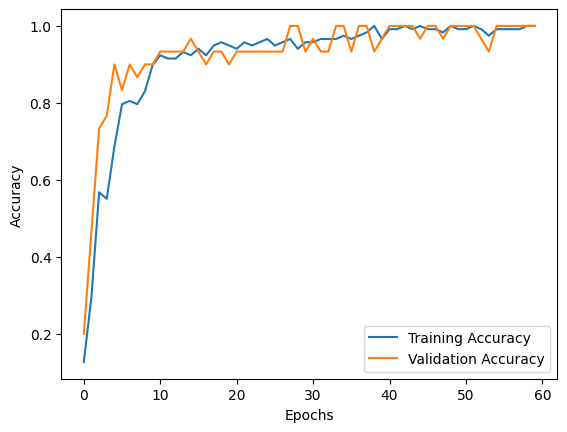

In [10]:
# رسم نمودار دقت بر حسب epoch‌ها
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**نمودار برای دیدن دقت کد بر اساس داده های تست در قالب  ماتریس کانفیوژن**

Class carton: Example filename -> Carton_3 - Copy.wav
Class Glass: Example filename -> Glass_55.wav
Class metal: Example filename -> Metal_68.wav
Class Pelastic: Example filename -> Plastic_55.wav
Class Roll: Example filename -> Roll_9.wav
Class Seramic: Example filename -> Seramic_09.wav
Class Wood: Example filename -> Wood_4.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
              precision    recall  f1-score   support

      carton       1.00      1.00      1.00         6
       Glass       1.00      1.00      1.00         3
       metal       1.00      1.00      1.00         4
    Pelastic       1.00      1.00      1.00         1
        Roll       1.00      1.00      1.00         6
     Seramic       1.00      1.00      1.00         6
        Wood       1.00      1.00      1.00         4

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



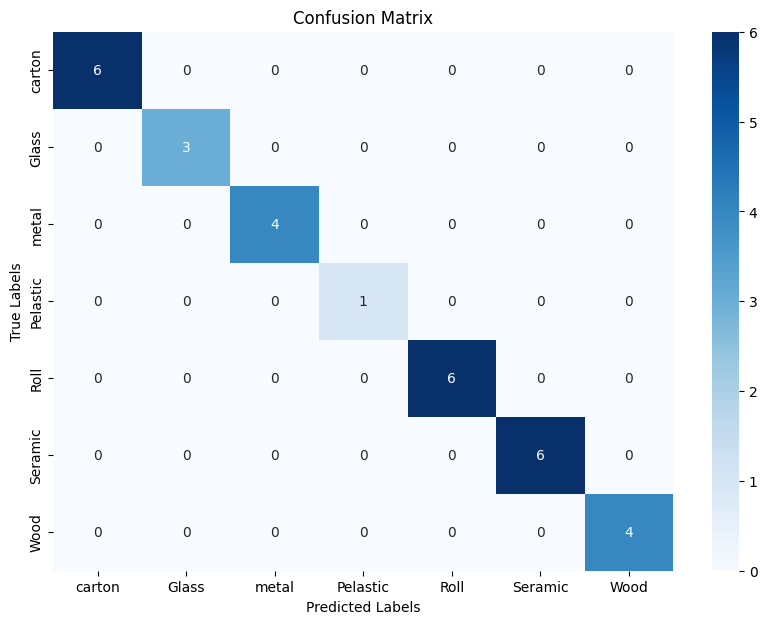

In [11]:
class_names = ['carton', 'Glass', 'metal', 'Pelastic', 'Roll', 'Seramic', 'Wood']  # نام کلاس‌ها

#  نمایش یکی از نمونه‌های نام فایل برای هر کلاس برای پیدا کردن نام دسته
for label in np.unique(y_test):
    sample_idx = np.where(y_test == label)[0][0]  # گرفتن ایندکس اولین نمونه
    print(f"Class {class_names[label]}: Example filename -> {filenames_test[sample_idx]}")

# پیش‌بینی دسته‌ها
y_pred = np.argmax(model.predict(X_test), axis=1)

# نمایش ماتریس
cm = confusion_matrix(y_test, y_pred)


#گزارش عملکرد
print(classification_report(y_test, y_pred, target_names=class_names))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


**نمایش تست ها**

In [12]:
# پیش‌بینی برچسب جنسیت
predictions = model.predict(X_test)

# تبدیل پیش‌بینی‌ها به برچسب‌های اصلی
predicted_labels = encoder.inverse_transform(np.argmax(predictions, axis=1))
true_labels = encoder.inverse_transform(y_test)


#نمایش تست
num_samples = max(10, len(X_test))
for i in range(num_samples):
    print(f"Sample {i+1}:")
    print(f"File: {filenames_test[i]}")
    print(f"True label: {true_labels[i]}")
    print(f"Predicted label: {predicted_labels[i]}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Sample 1:
File: Metal_68.wav
True label: Metal
Predicted label: Metal
--------------------------------------------------
Sample 2:
File: Metal_66.wav
True label: Metal
Predicted label: Metal
--------------------------------------------------
Sample 3:
File: Metal_54.wav
True label: Metal
Predicted label: Metal
--------------------------------------------------
Sample 4:
File: Metal_57.wav
True label: Metal
Predicted label: Metal
--------------------------------------------------
Sample 5:
File: Wood_4.wav
True label: Wood
Predicted label: Wood
--------------------------------------------------
Sample 6:
File: Seramic_09.wav
True label: Seramic
Predicted label: Seramic
--------------------------------------------------
Sample 7:
File: Carton_3 - Copy.wav
True label: Carton
Predicted label: Carton
--------------------------------------------------
Sample 8:
File: Roll_9.wav
True label: Roll
Predicted label: Roll
--------------------------------------

**نمایش 3 پیشبینی با بیشترین احتمال**

In [13]:
def predict_sound_type_with_reasons(file_path):
    # بارگذاری فایل صوتی
    audio, sr = librosa.load(file_path, sr=None)

    # اعمال حذف نویز
    audio = preprocess_audio(audio, sr)

    # استخراج ویژگی‌ها از فایل صوتی جدید
    features = extract_features(file_path)

    # تغییر شکل ویژگی‌ها به صورت مناسب برای مدل
    features = features.reshape(1, -1)

    # پیش‌بینی با مدل
    predictions = model.predict(features)

    # سه پیش‌بینی برتر و درصد‌هایشان
    top_3_indices = np.argsort(predictions[0])[::-1][:3]  # ایندکس‌های سه پیش‌بینی برتر
    top_3_probabilities = predictions[0][top_3_indices]  # درصد شباهت سه پیش‌بینی برتر

    # تبدیل ایندکس‌ها به نام جنس
    top_3_names = encoder.inverse_transform(top_3_indices)

    # دلایل انتخاب (بر اساس ویژگی‌های برجسته)
    dominant_features = features[0]  # ویژگی‌های ورودی
    important_features = np.argsort(dominant_features)[::-1][:7]  # سه ویژگی مهم

    reasons = [
        f"Feature {i} with value {dominant_features[i]:.4f}"
        for i in important_features
    ]

    return {
        "Top Predictions": [
            {"Type": name, "Similarity": f"{prob*100:.2f}%", "Reason": reasons}
            for name, prob in zip(top_3_names, top_3_probabilities)
        ]
    }

In [15]:
# تست مدل با فایل صوتی جدید
test_file = r"/content/drive/MyDrive/Colab Notebooks/AI_Project_AudioDetection/test/در قوری.wav"  # مسیر به فایل صوتی تست شما
result = predict_sound_type_with_reasons(test_file)

# نمایش سه پیش‌بینی برتر
for idx, prediction in enumerate(result["Top Predictions"], start=1):
    print(f"Prediction {idx}:")
    print(f"  Type: {prediction['Type']}")
    print(f"  Similarity: {prediction['Similarity']}")
    print()

print(f"  Reasons: {', '.join(prediction['Reason'])}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction 1:
  Type: Metal
  Similarity: 95.68%

Prediction 2:
  Type: Pelastic
  Similarity: 1.96%

Prediction 3:
  Type: Carton
  Similarity: 1.43%

  Reasons: Feature 1 with value 84.2023, Feature 3 with value 36.4675, Feature 2 with value 19.4242, Feature 13 with value 19.2450, Feature 18 with value 17.7276, Feature 19 with value 17.1920, Feature 17 with value 15.9307


In [16]:
# تست مدل با فایل صوتی جدید
test_file = r"/content/drive/MyDrive/Colab Notebooks/AI_Project_AudioDetection/test/پایه میز.wav"  # مسیر به فایل صوتی تست شما
result = predict_sound_type_with_reasons(test_file)

# نمایش سه پیش‌بینی برتر
for idx, prediction in enumerate(result["Top Predictions"], start=1):
    print(f"Prediction {idx}:")
    print(f"  Type: {prediction['Type']}")
    print(f"  Similarity: {prediction['Similarity']}")
    print()

print(f"  Reasons: {', '.join(prediction['Reason'])}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction 1:
  Type: Metal
  Similarity: 99.45%

Prediction 2:
  Type: Pelastic
  Similarity: 0.44%

Prediction 3:
  Type: Carton
  Similarity: 0.05%

  Reasons: Feature 1 with value 72.5025, Feature 3 with value 30.5587, Feature 13 with value 18.0171, Feature 18 with value 16.8498, Feature 19 with value 16.4302, Feature 17 with value 15.9818, Feature 16 with value 14.4989
